# Uttam Rao (ur6yr)

# CODEATHON 3: Recognizing UVA landmarks with neural nets (50 pts)
![UVA Grounds](http://faculty.virginia.edu/lazzara/images/UVAgrounds.jpg) 

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country. Throughout its history, the University of Virginia has won praise for its unique Jeffersonian architecture. 

In this codeathon, you will attempt the build an image recognition system to classify different buildlings/landmarks on Grounds. Your will earn 50 points for this codeathon plus 5 bonus points. Part of the total grade (10 pts) is for contributing 100+ images to the dataset, and the 5 bonus pts are for contributing 200+ images to the dataset.

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your need. You must submit the .ipynb file via UVA Collab with the following format: yourcomputingID_codeathon_3.ipynb

Thank you for collecting part of the dataset, best of luck, and have fun! 

# Load Packages

In [0]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(49)
tf.random.set_seed(49)

TensorFlow 2.x selected.


# Import Dataset
The full dataset is huge (+37GB) with +13K images. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been extracted to Dropbox to containly only 5 classes and 10 images each. 

Later, we will share a lite version of the data via another dropbox URL. This dataset will contain all 18 classes, and 100 images each. This dataset will be the one you will benchmark for your grade. If you are up for a challenge (and perhaps bonus points), contact the instructor for the full dataset!

#### Here I load the bigger dataset (18 classes) that's used for grading

In [0]:
# Download dataset from Dropbox
#!wget "https://www.dropbox.com/s/886irdf2eb5nwgu/UVALandmark5.zip"
#!wget "https://www.dropbox.com/s/gfsrcxarm30ryv1/UVALandmark18.zip"
#!wget https://uvalandmark18.s3.amazonaws.com/UVALandmark5.zip
!wget https://uvalandmark18.s3.amazonaws.com/UVALandmark18.zip

--2019-11-30 22:58:59--  https://uvalandmark18.s3.amazonaws.com/UVALandmark18.zip
Resolving uvalandmark18.s3.amazonaws.com (uvalandmark18.s3.amazonaws.com)... 52.216.94.187
Connecting to uvalandmark18.s3.amazonaws.com (uvalandmark18.s3.amazonaws.com)|52.216.94.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6194605880 (5.8G) [application/zip]
Saving to: ‘UVALandmark18.zip’

UVALandmark18.zip   100%[===================>]   5.77G  29.2MB/s    in 2m 46s  

2019-11-30 23:01:45 (35.6 MB/s) - ‘UVALandmark18.zip’ saved [6194605880/6194605880]



In [0]:
# Extract content
#!unzip "/content/UVALandmark5.zip"
!unzip "/content/UVALandmark18.zip"

Archive:  /content/UVALandmark18.zip
warning [/content/UVALandmark18.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
   creating: UVALandmark18/
   creating: UVALandmark18/Academical Village/
  inflating: UVALandmark18/Academical Village/ks5qug:1574201282238  
  inflating: UVALandmark18/Academical Village/Mec2wr:1574176804076  
  inflating: UVALandmark18/Academical Village/jw6qs:1574027372543  
  inflating: UVALandmark18/Academical Village/jw6qs:1574027360247  
  inflating: UVALandmark18/Academical Village/Mec2wr:1574176408847  
  inflating: UVALandmark18/Academical Village/asz9qm:1574276428474  
  inflating: UVALandmark18/Academical Village/asz9qm:1574276517718  
  inflating: UVALandmark18/Academical Village/ANON:1574177114794  
  inflating: UVALandmark18/Academical Village/Mec2wr:1574176921561  
  inflating: UVALandmark18/Academical Village/.DS_St

#### Get rid of the .DS_Store files. Code taken from piazza

In [0]:
import os
PATH = "/content/UVALandmark18"
for folder in os.listdir(PATH):
    ds_store = PATH+"/"+folder+"/.DS_Store"
    if os.path.exists(ds_store):
        os.remove(ds_store)

In [0]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

# define function to load train, test, and validation datasets
def load_dataset(path, num_classes):
    #Load text files with categories as subfolder names.
    data = load_files(path)
    filenames = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), num_classes)
    return filenames, targets

#n_classes = 5;
n_classes = 18;
# Make sure you create the class names that match the order of their appearances in the "files" variable
#class_names = ["Chapel", "Olsson", "Rice", "Rotunda", "Scott"]
class_names = ["Academical Village","Alderman Library","Alumni Hall","Aquatic & Fitness Center","Bavaro Hall","Brooks Hall",
               "Clark Hall","Madison Hall","Minor Hall","New Cabell Hall","Newcomb Hall","Old Cabell Hall","Olsson Hall",
               "Rice Hall","Rotunda","Scott Stadium","Thornton Hall","University Chapel"]
# load train, test, and validation datasets
#files, targets = load_dataset('/content/UVALandmark5/',n_classes)
files, targets = load_dataset('/content/UVALandmark18/',n_classes)
print(type(files), files)   

Using TensorFlow backend.


<class 'numpy.ndarray'> ['/content/UVALandmark18/Bavaro Hall/csn5aw:1573933936836'
 '/content/UVALandmark18/Brooks Hall/xy3jh :1574189685070'
 '/content/UVALandmark18/Olsson Hall/yl9gq:1574017354270' ...
 '/content/UVALandmark18/Madison Hall/ks5qug:1574201675326'
 '/content/UVALandmark18/Minor Hall/dbl3jf :1574194956314'
 '/content/UVALandmark18/Rice Hall/Jwh6ry :1574275138938']


In [0]:
from sklearn.model_selection import train_test_split
# Split to train-validate-test sets. DO NOT CHANGE THE TEST RATIO OR RANDOM STATE
train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=0.3, random_state=49)
train_files, val_files, train_targets, val_targets = train_test_split(train_files, train_targets, test_size=0.2, random_state=49)

In [0]:
from keras.preprocessing import image
from tqdm import tqdm # progress bar

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)           

# pre-process the data for Keras - Converts to (224, 224) and converts into a numpy array using PIL.
# NOTE: This code does not include any data augmentation, but you can modify it to include the augmentation operation.
X_train = paths_to_tensor(train_files).astype('float32')/255
X_val = paths_to_tensor(val_files).astype('float32')/255
X_test = paths_to_tensor(test_files).astype('float32')/255
# Convert y_targets into labels
y_train = np.asarray([np.where(r==1)[0][0] for r in train_targets], dtype=np.uint8)
y_test = np.asarray([np.where(r==1)[0][0] for r in test_targets], dtype=np.uint8)
y_val = np.asarray([np.where(r==1)[0][0] for r in val_targets], dtype=np.uint8)

100%|██████████| 642/642 [02:07<00:00,  5.64it/s]


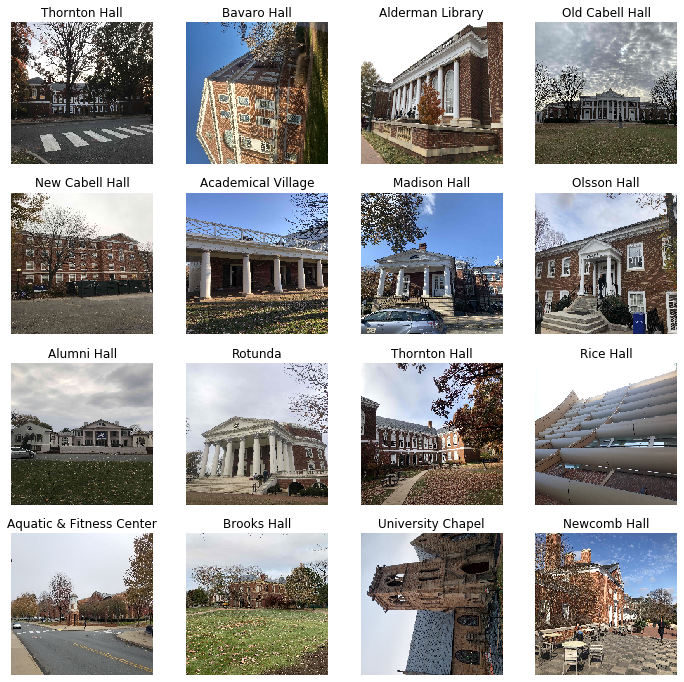

In [0]:
# Visualize some of the train samples
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


# It's your turn: Building a classifier for UVA Landmark Dataset
You may design your own architecture OR re-use any of the exising frameworks (recommended). 

Best of luck!

#### I thoroughly looked at Colab 14 (deep computer vision with cnns), particularly the "pretrained models for transfer learning section). I determined that using the pretrained Keras model (xception v1) that the example used would be most effective for the image classification task at hand. The summary of the layers of the model I used is outputed by the cell below. I first fit the model with the smaller dataset with only 5 classes to gauge its performance and tune it a little. I quickly realized that this pretrained cnn was very powerful and didn't need much tuning. I fit the model with the training set and validated it with the validation set for each epoch.

### The code below shows the process for the larger dataset (18 classes) which is used for grading. As we can see the accuracy is 90.34%. Adding a couple more layers and fiddling with some of the parameters can bring this up to around 94.85%, which is the highest I got. I've only included the output for the 90.34% accuracy one that I got, however, as my runtime disconnected for the other one without saving the output. Also 90.34% accuracy is sufficient for full credit on this assignment so I didn't bother redoing it (it took 3 hours to run, although I probably didn't need to train it that much to get over seventy five percent). Hope you had a great Thanksgiving!

In [0]:
# YOUR CODE STARTS HERE
#dataset_size = X_train.shape[0]
#batch_size = 32
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)
print(model.summary())

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_____________________________

In [0]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train,
                    validation_data=[X_val, y_val],
                    epochs=10, batch_size=32)

Train on 1196 samples, validate on 300 samples
Epoch 1/10
1196/1196 [==============================] - 1275s 1s/sample - loss: 2.2748 - accuracy: 0.3328 - val_loss: 1.9482 - val_accuracy: 0.3467
Epoch 2/10
1196/1196 [==============================] - 1265s 1s/sample - loss: 0.7338 - accuracy: 0.8554 - val_loss: 1.1303 - val_accuracy: 0.6500
Epoch 3/10
1196/1196 [==============================] - 1265s 1s/sample - loss: 0.2014 - accuracy: 0.9682 - val_loss: 0.5773 - val_accuracy: 0.8367
Epoch 4/10
1196/1196 [==============================] - 1259s 1s/sample - loss: 0.0625 - accuracy: 0.9950 - val_loss: 0.4746 - val_accuracy: 0.8667
Epoch 5/10
1196/1196 [==============================] - 1254s 1s/sample - loss: 0.0341 - accuracy: 0.9975 - val_loss: 0.4156 - val_accuracy: 0.8733
Epoch 6/10
1196/1196 [==============================] - 1252s 1s/sample - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.3995 - val_accuracy: 0.8800
Epoch 7/10
1196/1196 [==============================] - 1254s 1s/

In [0]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 90.34%
